In [1]:
# utility
import sys
sys.path.append("..")

import utility

# data processing
import numpy as np

# modelling
from sklearn.neighbors import LocalOutlierFactor

# Tree Visualization
import matplotlib.pyplot as plt

In [2]:
train_data, test_data, train_labels, test_labels, test_true_labels = utility.preprocess_data(False)

In [3]:
# data shape
print(train_data.shape)
print(test_data.shape)

# labels shape
print(train_labels.shape)
print(test_labels.shape)
print(test_true_labels.shape)

(25875, 784)
(8625, 784)
(25875,)
(8625,)
(8625,)


Dataset split: 25875 train rows
Dataset split: 25875 test rows


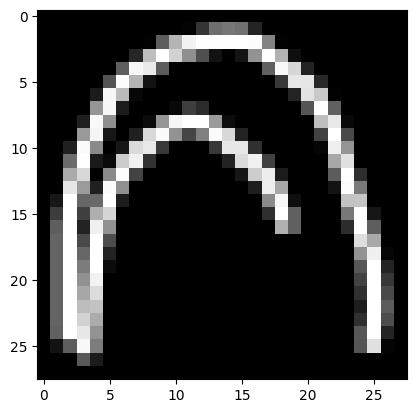

In [4]:
print(f"Dataset split: {len(train_data)} train rows")
print(f"Dataset split: {len(train_labels)} test rows")

point = train_data[0].reshape(28, 28)

plt.imshow(point, cmap='gray')
plt.show()

In [7]:
# Train the LOF model using data generator
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.05, novelty=True)

for batch in utility.data_generator(train_data):
    # Train the LOF model
    lof.fit(batch)

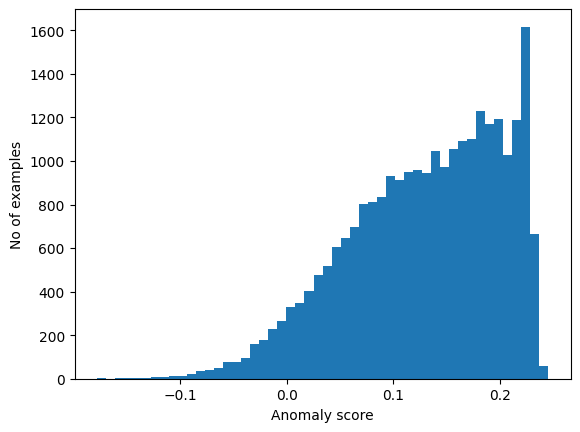

In [9]:
scores = lof.decision_function(train_data)

plt.hist(scores[:], bins=50)
plt.xlabel("Anomaly score")
plt.ylabel("No of examples")
plt.show()

In [11]:
# predict
preds = []
for batch in utility.data_generator(test_data):
    # Predict anomalies
    batch_pred = lof.predict(batch)
    preds.extend(batch_pred)

# Convert to boolean values
preds = [pred == 1 for pred in preds]

# Convert to numpy array
preds = np.array(preds)

In [12]:
# anomaly scores
anomaly_scores = lof.decision_function(test_data)

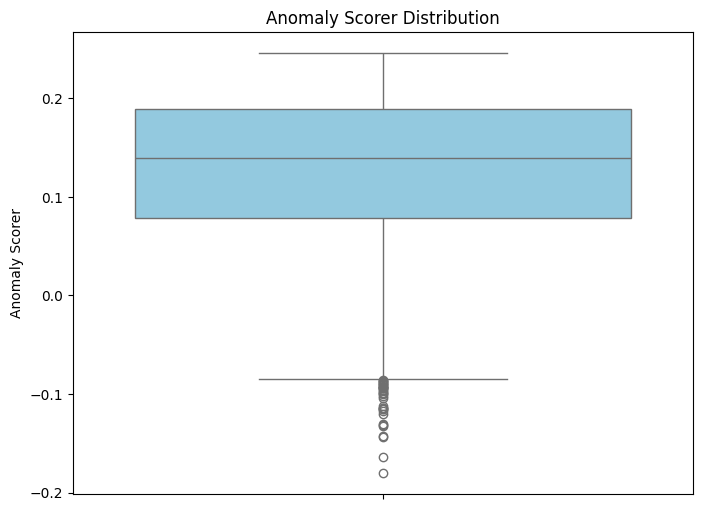

In [13]:
utility.boxplot_plot("Anomaly Scorer", anomaly_scores)

C:\Users\zippe\AppData\Local\Temp\ipykernel_8888\2519498737.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(range(len(anomaly_scores)), anomaly_scores, c=['blue' if e > threshold else 'red' for e in anomaly_scores], cmap='coolwarm', marker='o', edgecolors='k')


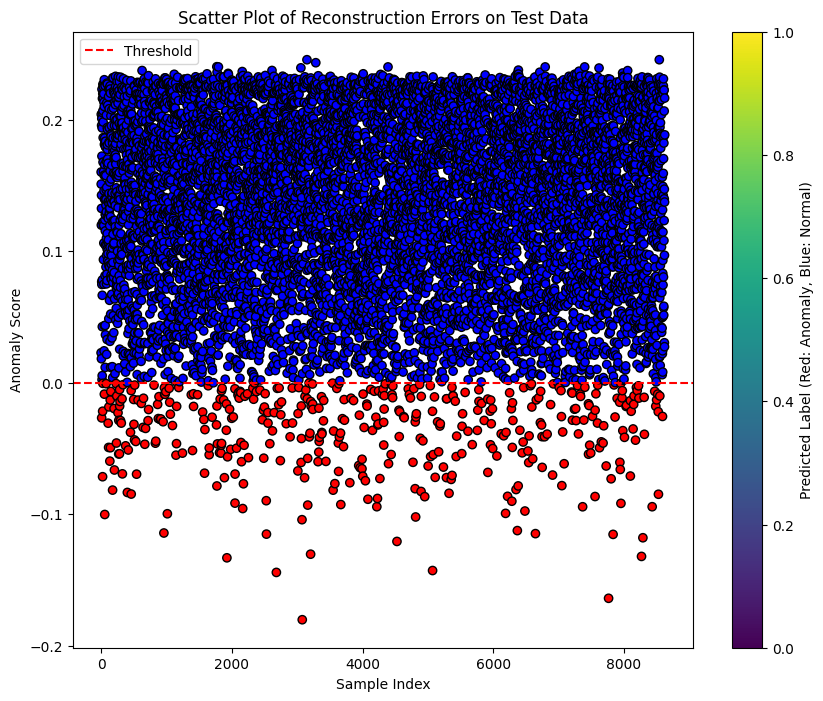

In [14]:
# Set a threshold for classifying anomalies
threshold = 0.0 # Adjust this threshold as needed

# Create a binary array indicating anomalies
anomaly_indicator = np.where(anomaly_scores > threshold, 1, 0)

# Scatter plot with anomalies and normal instances based on anomaly prediction and threshold
plt.figure(figsize=(10, 8))
scatter = plt.scatter(range(len(anomaly_scores)), anomaly_scores, c=['blue' if e > threshold else 'red' for e in anomaly_scores], cmap='coolwarm', marker='o', edgecolors='k')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.title('Scatter Plot of Reconstruction Errors on Test Data')
plt.xlabel('Sample Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.colorbar(scatter, label='Predicted Label (Red: Anomaly, Blue: Normal)')
plt.show()

In [15]:
a, p, r, report, cm = utility.get_metrics(preds, test_true_labels)

c:\Users\zippe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zippe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zippe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [16]:
utility.print_stats(a, p, r, report, cm)

Accuracy = 0.9506086956521739
Precision = 1.0
Recall = 0.9506086956521739
Report
               precision    recall  f1-score   support

     anomaly       0.00      0.00      0.00         0
      normal       1.00      0.95      0.97      8625

    accuracy                           0.95      8625
   macro avg       0.50      0.48      0.49      8625
weighted avg       1.00      0.95      0.97      8625

Confusion Matrix
[[   0    0]
 [ 426 8199]]


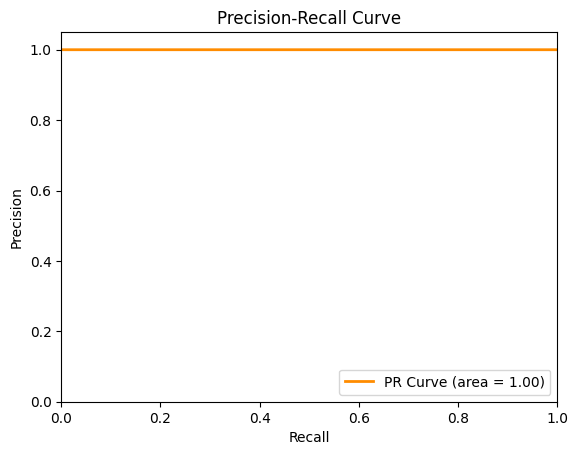

In [17]:
utility.pr_auc_plot(anomaly_scores, test_true_labels, True)

In [18]:
utility.roc_plot(preds, test_true_labels)

Only one class present in y_true. ROC AUC score is not defined in that case.


True Negatives: 0
False Positives: 0
False Negatives: 426
True Positives: 8199


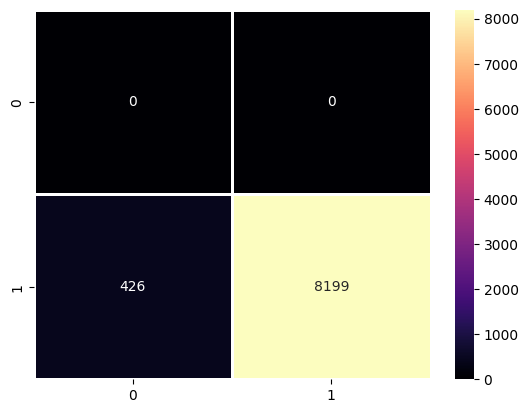

In [19]:
utility.create_heatmap(cm)

In [20]:
anomaly_indexes = utility.write_to_json(preds)

Anomaly indexes saved to .\anomalies.json


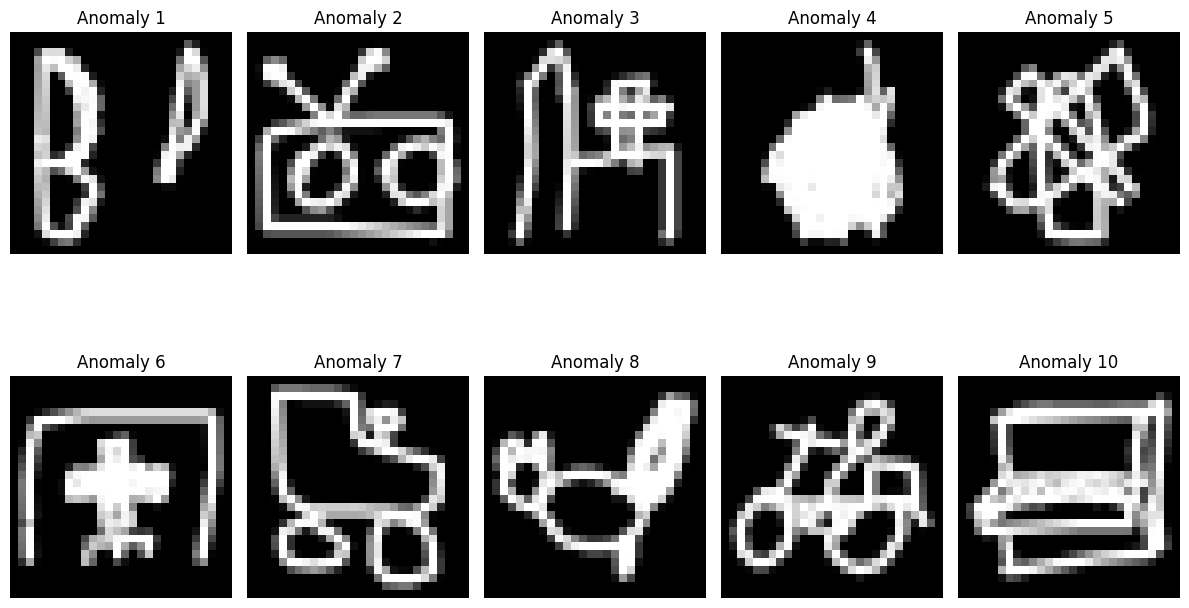

In [21]:
utility.plot_anomaly_imgs(anomaly_indexes, test_data)